<a href="https://colab.research.google.com/github/jcumbicosr/processamento-linguagem-natural/blob/main/Embeddings_gerados_por_BERT_pr%C3%A9_treinado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 3_4 - BERT

Nome: JoseCR


## Instruções:


Criar um modelo de linguagem e medir a perplexidade utilizando o dataset do Machado de Assis, utilizando Embeddings gerados por um BERT pré-treinado e uma MLP.

- Deve-se implementar o próprio laço de treinamento. **Não usar frameworks de treinamento automático.**
- Utilizar o BertModel.from_pretrained e BertTokenizer.from_pretrained do Hugging Face para carregar o BERT pré-treinado.
- Não utilize outras classes da HuggingFace/Transformers alem da [BertModel](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel) e [BertTokenizer](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertTokenizer).
- Experimente com aumentar do contexto (definido pelo tokenizer) e congelar ou não os parâmetros do BERT.
- Sugerimos utilizar um BERT treinado em português como o BerTimbau: "neuralmind/bert-base-portuguese-cased".
- Inicialmente utilizar o hidden_state do token CLS. Podem experimentar com outras formas de usar o last_hidden_state.
- MLP deve utilizar o vocab_size do BERT

Opcional:
- Utilize bfloat16 para economizar memória da GPU.

In [ ]:
from transformers import BertModel, BertTokenizer
from collections import Counter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
import random
import os
import re

In [ ]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dados

Vamos usar o mesmo dataset do Machado de Assis.



In [ ]:
!git clone https://github.com/ethelbeluzzi/projetomachado

Cloning into 'projetomachado'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (65/65), 7.21 MiB | 3.84 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
DATA_PATH = os.path.join("projetomachado", "textonormalizado1000.txt")

min_words = 6 # Minimum number of words per line
cleaned_lines = []
line_lens = []
total_words = 0
# Abrir arquito textual e ler os dados originais
with open(DATA_PATH, "r") as data_file:
    for line in data_file:
        # Limpar linhas, removendo \n, espaços antes e depois
        line = line.strip().lower()
        # Remove punctuation marks, except , and.
        line = re.sub(r'[^\w\s,.]', '', line)
        # Apagar linhas menor que min_words
        num_words = len(line.split())
        if num_words < min_words:
            continue
        # Contador de palavras
        total_words += num_words
        cleaned_lines.append(line)
        line_lens.append(len(line))
print(f'Total de linhas: {len(cleaned_lines)}')
print(f'Total de palavras: {total_words}')
print(f'Total de caracteres: {sum(line_lens)}')

Total de linhas: 233809
Total de palavras: 3086352
Total de caracteres: 17226274


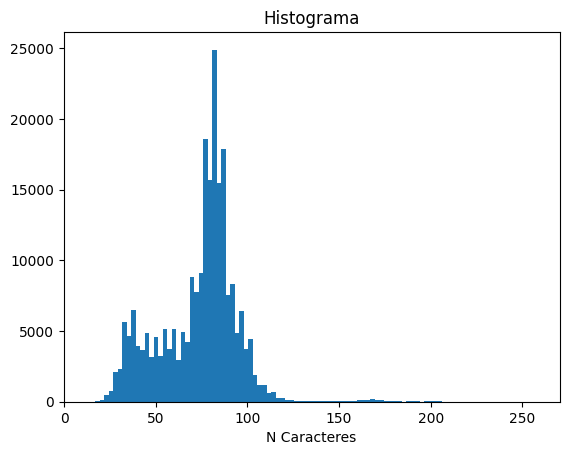

In [ ]:
plt.title("Histograma")
plt.hist(line_lens, bins=100)
plt.xlabel("N Caracteres")
plt.show()

## Classe do dataset

Utilize o Tokenizer do Bert na classe Dataset.
Defina um tamanho de sequencia/contexto.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [ ]:
cleaned_lines = cleaned_lines[:1000]

In [ ]:
from torch.utils.data import Dataset, DataLoader

context_size = 5 # 5 palavras de entrada. O target é a próxima palavra

"""TODO: Preparar o dataset"""

class MachadoDataset(Dataset):
    def __init__(self, text, context_size, tokenizer):
        self.context_size = context_size

        mono_words = []
        inputs = []
        output = []
        for line in text:
            words = self.split_text(line)
            mono_words.extend(words)

        # slicing windows
        for i in range(len(mono_words)-context_size-1):
            data = mono_words[i:i+context_size+1]
            # Check if target contains a single token
            tgt = tokenizer.tokenize(data[-1])
            if len(tgt) != 1:
                continue

            inputs.append(' '.join(data[:-1]))
            output.append(data[-1])

        # Tokenizer data
        src = tokenizer(inputs, return_tensors='pt',
                        max_length=context_size + 5, # sos + eos + 3
                        padding='max_length', truncation=True)
        self.source = src.input_ids
        self.mask = src.attention_mask
        self.target = tokenizer(output, return_tensors='pt').input_ids[:,1]

    @staticmethod
    def split_text(text):
        return re.findall(r'\w+|[.,]', text)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        src = {'src':self.source[idx], 'mask':self.mask[idx]}
        return src, self.target[idx]

my_dataset = MachadoDataset(cleaned_lines, context_size, tokenizer)
sample = my_dataset[0]
print(f'Length of Dataset: {len(my_dataset)}')
print('==> Sample <==')
print(f'Source: {sample[0]}')
print(f'Target: {sample[1]}')

Length of Dataset: 13638
==> Sample <==
Source: {'src': tensor([  101,  8111,   179, 12947,  5308,   185,  1659,   102,     0,     0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])}
Target: 117


In [ ]:
"""TODO: divida o dataset em validação/treino com um proporção de 20/80 %. OBS, use random_state=18"""

from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(my_dataset, test_size=0.2, random_state=18)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

sample = next(iter(train_loader))
print(f'Shape of source: {sample[0]["src"].shape}')
print(f'Shape of target: {sample[1].shape}')

Shape of source: torch.Size([128, 10])
Shape of target: torch.Size([128])


## Model

In [ ]:
class LanguageModel(torch.nn.Module):
    """TODO: implementar o modelo de linguagem"""
    def __init__(self, ff_hidden_layer):
        """TODO:
        Iniciliazar o BERT
        Inicializar MLP de predição de próxima palavra utilizando o hidden state do ultimo token no BERT
        Usar tamanho do vocabulário do BERT
        Sinta-se livre para também experimentar com outras formas de usar o last_hidden_state.
        """
        super(LanguageModel, self).__init__()
        self.bert = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
        # Initialize last linear layers
        self.fc1 = nn.Linear(self.bert.config.hidden_size, ff_hidden_layer)
        self.fc2 = nn.Linear(ff_hidden_layer, self.bert.config.vocab_size)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # Get [cls] token
        cls_output = outputs.pooler_output
        # Pass through MLP
        x = F.relu(self.fc1(cls_output))
        logits = self.fc2(x)
        return logits

# Define hyperparameters
hidden_size = 512          # Number of neurons in the hidden layer

# Model instantiation
model = LanguageModel(hidden_size)

#print(model)
# Count number of parameters
#print("\nParameters by layer:")
#for p in model.parameters():
#    print(p.shape)

# Convert parameters of model to list
params = list(model.named_parameters())

# Print parameters of two last layer
for name, param in params[-4:]:
    print(f"Layer: {name} | Size: {list(param.size())}")

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal number of parameters: {total_params}")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Layer: fc1.weight | Size: [512, 768]
Layer: fc1.bias | Size: [512]
Layer: fc2.weight | Size: [29794, 512]
Layer: fc2.bias | Size: [29794]

Total number of parameters: 124601186


In [ ]:
sample = next(iter(train_loader))

# Forward pass
ouput = model(sample[0]['src'], sample[0]['mask'])
print(f'Shape of output: {ouput.shape}')
print(f'Vocab size: {model.bert.config.vocab_size}')
print(f'Tokenizer vocab size: {tokenizer.vocab_size}')

Shape of output: torch.Size([128, 29794])
Vocab size: 29794
Tokenizer vocab size: 29794


## Train model

In [ ]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import time

epochs = 5
lr = 5e-4; """TODO, experimente!"""
criterion = nn.CrossEntropyLoss(); """TODO CrossEntropy"""

# Model instantiatio
model = LanguageModel(hidden_size)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Freeze all parameters model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze parameters of last linear layers
for param in model.fc1.parameters():
    param.requires_grad = True
for param in model.fc2.parameters():
    param.requires_grad = True


#optimizer = torch.optim.Adam(model.parameters(), lr=lr); """TODO: AdamW ou outro, experimente!"""
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

"""TODO: Implemente o loop de treinamento. Em cada época, calcule e imprima a loss no dataset de validação. Opcional: Plote um gráfico da loss de validação e treino"""

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    test_acc = 0.0
    for inputs, targets in train_loader:
        targets = targets.to(device)

        logits = model(inputs['src'].to(device), inputs['mask'].to(device))
        loss = criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = logits.argmax(dim=1)
        accuracy = (preds == targets).float().mean()
        test_acc += accuracy.item()

    return total_loss / len(train_loader), (test_acc / len(train_loader)) * 100

def valid_epoch(model, valid_loader, criterion, device):
    ## evaluation
    val_acc = 0
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            targets = targets.to(device)

            logits = model(inputs['src'].to(device), inputs['mask'].to(device))

            # Calculate loss
            loss = criterion(logits, targets)
            val_loss += loss.item()

            # Calculate acc
            preds = logits.argmax(dim=1)
            accuracy = (preds == targets).float().mean()
            val_acc += accuracy.item()

    return val_loss / len(val_loader), (val_acc / len(val_loader)) * 100

# Save history to dictionnary
history = {
    'train_loss': [],
    'eval_loss': [],
    'train_acc': [],
    'eval_acc': []
}

# Initial evaluation
val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)
perplexity = torch.exp(torch.tensor(val_loss))
print(f'[Initial] Test loss:{val_loss:.4f}, Test acc:{val_acc:.2f}%, Perplexity:{perplexity:.2f}')

# Training loop
for epoch in range(epochs):
    start_time_epoch = time.time()  # Start time of the epoch

    # train model
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # evaluate model
    val_loss, val_acc = valid_epoch(model, val_loader, criterion, device)

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time_epoch  # Duration of epoch

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(val_loss)
    history['eval_acc'].append(val_acc)

    perplexity = torch.exp(torch.tensor(val_loss))
    print(f'Epoch [{epoch+1}/{epochs}], Train loss:{train_loss:.4f}, Train acc:{train_acc:.2f}%, '
          f'Test loss:{val_loss:.4f}, Test acc: {val_acc:.2f}%, '
          f'Perplexity:{perplexity:.2f}, Elapsed Time: {epoch_duration:.2f} sec')

[Initial] Test loss:10.2953, Test acc:0.00%, Perplexity:29592.29
Epoch [1/5], Train loss:5.2160, Train acc:12.29%, Test loss:4.9117, Test acc: 14.01%, Perplexity:135.87, Elapsed Time: 1824.53 sec
Epoch [2/5], Train loss:4.9673, Train acc:13.38%, Test loss:4.8036, Test acc: 14.69%, Perplexity:121.95, Elapsed Time: 1824.87 sec
Epoch [3/5], Train loss:4.8967, Train acc:13.70%, Test loss:4.7696, Test acc: 14.78%, Perplexity:117.87, Elapsed Time: 1825.03 sec
Epoch [4/5], Train loss:4.8657, Train acc:13.84%, Test loss:4.7443, Test acc: 15.09%, Perplexity:114.93, Elapsed Time: 1825.62 sec
Epoch [5/5], Train loss:4.8489, Train acc:13.95%, Test loss:4.7381, Test acc: 15.20%, Perplexity:114.22, Elapsed Time: 1825.76 sec


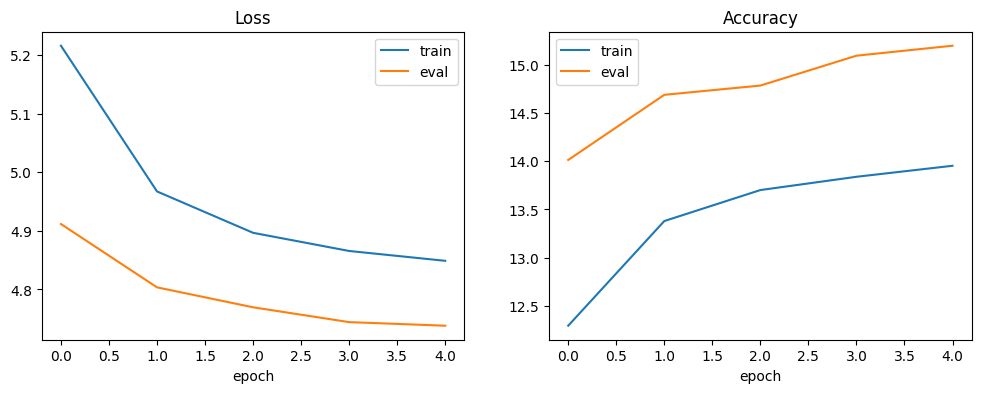

In [ ]:
# Plot loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['eval_loss'], label='eval')
plt.legend()
plt.title('Loss')
plt.xlabel('epoch')
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='train')
plt.plot(history['eval_acc'], label='eval')
plt.legend()
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

## Exemplo de uso

In [ ]:
"""TODO: implemente a função para gerar texto até atingir o max_length"""

class NextWord(nn.Module):
    def __init__(self, language_model, context_size, tokenizer):
        super(NextWord, self).__init__()
        self.model = language_model
        self.context_size = context_size
        self.vocab = tokenizer

    def __call__(self, text, max_length):
        input = self.vocab.encode(text, return_tensors='pt')
        # Delete sos and eos tokens
        input = input[:,1:-1].to(device)
        #print('input init: ', input)

        self.model.eval()
        print('Output: ', end='')
        for step in range(input.size(1), max_length):
             # Calculate the start index for slicing; ensure it's not negative
             start_idx = max(0, step - self.context_size)
             # Slice the input tensor to get the context
             context = input[:,start_idx:step]

             # add sos and eos tokens
             context = torch.cat((torch.tensor([[101]], device=device),
                                  context,
                                  torch.tensor([[102]], device=device)), dim=1)
             #print('Contex input: ', context)
             logits = self.model(context.to(device))
             output = logits.argmax(dim=1).unsqueeze(0)

             #print(f"Context: {context.tolist()} | Output: {output.tolist()}")
             print(output.squeeze(0).tolist(), end=' ')
             input = torch.cat((input, output), dim=1)

        outputs = input.squeeze(0).tolist()
        print('\nText: ')
        return self.vocab.decode(outputs)



next_word = NextWord(model, context_size, tokenizer)

print(f'\n===========> Test <===========')
text = "bom dia, tudo bem"
max_length= 100
next_word(text, max_length)


===========> Test <===========
Output: [117] [122] [346] [18661] [179] [146] [179] [311] [346] [4048] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] 
Text: 


'bom dia, tudo bem, e não sei que o que me não parece.....................................................................................'

In [ ]:
print(f'===========> Test <===========')
text = "que é uma boa literatura"
max_length= 150
next_word(text, max_length)

===========> Test <===========
Output: [117] [122] [179] [123] [1069] [123] [346] [2036] [2822] [119] [123] [117] [179] [123] [179] [123] [346] [2036] [1191] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] 
Text: 


'que é uma boa literatura, e que a vida a não lhe dar. a, que a que a não lhe fez a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão'

In [ ]:
print(f'===========> Test <===========')
text = "mas o que é verdade"
max_length= 130
next_word(text, max_length)

===========> Test <===========
Output: [179] [346] [253] [179] [146] [179] [311] [346] [4048] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] 
Text: 


'mas o que é verdade que não é que o que me não parece....................................................................................................................'

In [ ]:
print(f'===========> Test <===========')
text = "o chapéu grande precisa de"
max_length= 120
next_word(text, max_length)

===========> Test <===========
Output: [222] [125] [222] [117] [179] [346] [2036] [346] [2036] [2002] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] [4014] [117] [122] [123] 
Text: 


'o chapéu grande precisa de um de um, que não lhe não lhe deu a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a mão, e a'

In [ ]:
print(f'===========> Test <===========')
text = "excelente dia para ficar em"
max_length= 130
next_word(text, max_length)

===========> Test <===========
Output: [1105] [117] [122] [123] [327] [2196] [117] [122] [179] [346] [2036] [346] [311] [10201] [117] [122] [346] [18661] [179] [146] [179] [311] [346] [4048] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] [119] 
Text: 


'excelente dia para ficar em casa, e a sua mãe, e que não lhe não me lembra, e não sei que o que me não parece.....................................................................................................'